## Programmer: Giovanni Vecchione
## Date: 4/8/24
## Subject: Machine Learning 2 - Autoencoders, GANS, and Diffusion Models

Chapter 17. Autoencoders, GANs, and Diffusion Models

Goal: Use Generative Adversarial Networks (GAN) to build the project. Submit your project as Jupyter notebook

In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from keras.regularizers import l1
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from sklearn.utils import class_weight
from tensorflow.keras import backend as K 
from keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA


import re

seed = 42
random.seed(seed)

In [40]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


# **Autoencoders:**
1. Autoencoders can be used for dimensionality reduction. Another application is for unsupervised pretraining.

2. **Autoencoder as Feature Extractor:** An autoencoder can learn a compressed representation (an "encoding") of the key features from your real data. You can then use this encoding as a starting point for your GAN's generator, giving it a head start in understanding the underlying structure of the data. This can lead to faster GAN training and potentially more realistic outputs.

3. **Fighting Mode Collapse:** One challenge with GANs is "mode collapse", where the generator produces a limited variety of outputs, fooling the discriminator. An autoencoder can help here. By pre-training the discriminator on the task of reconstructing real data (like in an autoencoder setup) you can make it better at recognizing the wider variety of features present in the real dataset. This can help it push the generator to produce more diverse outputs.

4. **Handling Noisy Data:** If your real data set is noisy, you can use a denoising autoencoder as a pre-processing step. The autoencoder learns to reconstruct clean images from noisy versions. This cleaned-up data can then feed into your GAN, leading to better outputs.

5. **Creative Control:** You can build a hybrid model where the generator of a GAN produces the compressed representation (the "code") and the decoder of an autoencoder reconstructs the data from that code. This allows you to control generation with the compressed representation, leading to interesting image manipulation or style transfer effects.

### **Optimization:** When compiling the stacked autoencoder, we use the MSE loss and Nadam optimization.
### **Comparing input to output:** One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant.
### **Important Note:** While autoencoders can provide benefits, they aren't strictly necessary to build a GAN. 

# **Reducing Dimensions of a Dataset**
Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance—say, 95% (An exception to this rule, of course, is if you are reducing dimensionality for data visualization, in which case you will want to reduce the dimensionality down to 2 or 3).

The following code loads and splits the MNIST dataset (introduced in Chapter 3) and performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance:

In [41]:
#mnist = fetch_openml('mnist_784', as_frame=False)
#X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
#X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

#pca = PCA()
#pca.fit(X_train)
#cumsum = np.cumsum(pca.explained_variance_ratio_)
#d = np.argmax(cumsum >= 0.95) + 1  # d equals 154


In [42]:
#Checks Dimensions
#pca.explained_variance_ratio_

You could then set n_components=d and run PCA again, but there's a better option. Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [43]:
#pca = PCA(n_components=0.95)
#X_reduced = pca.fit_transform(X_train)

The actual number of components is determined during training, and it is stored in the n_components_ attribute:

In [44]:
#pca.n_components_

### **NOTE:** Lastly, if you are using dimensionality reduction as a preprocessing step for a supervised learning task (e.g., classification), then you can tune the number of dimensions as you would any other hyperparameter (see Chapter 2).

https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/ch08.html#idm45720209258688:~:text=Lastly%2C%20if%20you%20are%20using%20dimensionality%20reduction%20as%20a%20preprocessing%20step%20for%20a%20supervised%20learning%20task%20(e.g.%2C%20classification)%2C%20then%20you%20can%20tune%20the%20number%20of%20dimensions%20as%20you%20would%20any%20other%20hyperparameter%20(see%20Chapter%C2%A02).

## **Implementing a Stacked Autoencoder Using Keras**

In [45]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20


ValueError: Dimensions must be equal, but are 32 and 28 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](compile_loss/mse/Cast, sequential_17_1/sequential_16_1/reshape_5_1/Reshape)' with input shapes: [32,784], [32,28,28].

## **Visualizing the Reconstructions**

In [ ]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show()

## **Convolutional Autoencoders:**

In [ ]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

## Denoising Autoencoders:

In [ ]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# **What is a Generative Adversarial Network (GAN)?**

#### **The Art of Imitation:** GANs are a type of deep learning architecture where two neural networks are locked in an elaborate game of cat-and-mouse.  Think of them as a master art forger and an expert art critic:
   **The Generator:** The 'art forger' responsible for creating realistic fakes that could pass as authentic pieces (e.g., images, music, text etc.).
     
   **The Discriminator:**  The 'art critic'  trained to tell the difference between a genuine masterpiece and the generator's forgeries.

#### **A Competitive Game:**  Both networks get better through this competition.  The generator keeps refining its fakes to fool the discriminator, and the discriminator gets better at spotting the subtle flaws in those fakes. Over time, the generator gets so good that its creations become indistinguishable from real data.

## Basic Concepts

1. **Unsupervised Learning:** GANs don't need labeled data. They learn from a dataset of examples (e.g., a collection of real photographs), extracting the patterns and underlying structure without explicit labels like "dog" or "cat."

2. **Generator Network:**
   * Takes random noise as input.
   * Tries to transform that noise into data that resembles the real examples it has seen.
   * Its goal is to make the discriminator believe its outputs are real.

3. **Discriminator Network:**
   * Takes as input both real data samples and the generator's outputs.
   * Tries to classify whether an input is "real" (from the training dataset) or "fake" (created by the generator).
   * Gives feedback to the generator to help it improve its fakes.

4. **Adversarial Training:**
   * The generator and discriminator are trained simultaneously.
   * The generator improves by making the discriminator's job harder.
   * The discriminator improves by becoming a better judge of authenticity.
   * It's this constant push-and-pull that makes GANs so powerful.

**Why use GANs?**

* **Generating New Data:** Create realistic images, music, videos, or other data forms that weren't in your original dataset.
* **Data Augmentation:** Increase the size and diversity of a dataset, useful in areas where real data is scarce.
* **Image-to-Image Translation:** Change images from one style to another (e.g., turning sketches into photos).
* **Super Resolution:** Enhancing image or video quality.

**Ready to Build?**

Building a GAN involves:

* **Choosing Your Domain:**  Images, text, audio, etc.
* **Data Preparation:**  Gathering or creating a suitable dataset.
* **Network Architecture:**  Designing your generator and discriminator networks (often using convolutional neural networks for images).
* **Training Setup:**  Defining the loss functions that guide the networks and selecting an optimization algorithm. 
* **Implementation:**  Coding your GAN using a deep learning framework like TensorFlow or PyTorch.




## Basic GAN Model:

First, we need to build the generator and the discriminator. The generator is similar to an autoencoder's decoder, and the discriminator is a regular binary classifier: it takes an image as input and ends with a Dense layer containing a single unit and using the sigmoid activation function. For the second phase of each training iteration, we also need the full GAN model containing the generator followed by the discriminator:

In [67]:
#import Dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

#split dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [68]:
#Preprocessing:

# Data Conversion and Normalization
train_images = tf.cast(train_images, tf.float32)  # Convert to float32 / this type is needed, MNIST is unit8 type
train_images /= 255.0  # Normalize to [0, 1] range

# Do the same for the test dataset if needed:
test_images = tf.cast(test_images, tf.float32)
test_images /= 255.0  

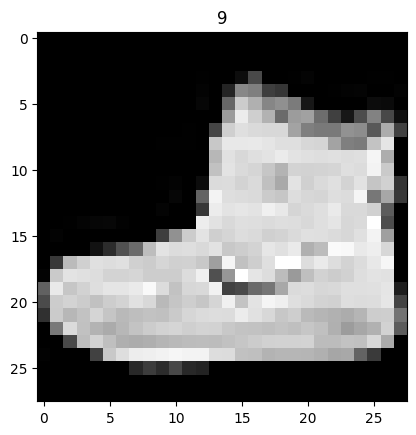

In [69]:
# Let's look at the first image and its label
plt.imshow(train_images[0], cmap='gray')
plt.title(train_labels[0])
plt.show()

In [70]:
codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [71]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")



**Code Explination**

```python
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
```

* **Compiling the Discriminator:**
    * `loss="binary_crossentropy"`: This is a standard choice for a discriminator classifying real vs. fake images.
    * `optimizer="rmsprop"`:  RMSprop is a decent optimizer, though Adam is more common in GANs. Experiment to see what works best for you.

* **`discriminator.trainable = False`:** 
    * **Key Concept:** You're freezing the discriminator's weights during the initial stages of training the generator. This is done because you want the generator to get better at producing plausible fakes *before* the discriminator gets too good at spotting them. 

* **Compiling the GAN:**
    *  You're compiling the combined GAN model (generator + discriminator) with the same loss and optimizer. This sets the stage for adversarial training.

**Important Points**

1. **Training Phases:**  GAN training often involves alternating phases:
    * **Train the Discriminator:** Set `discriminator.trainable = True`, train it on a mix of real and fake images.
    * **Train the Generator:** Set `discriminator.trainable = False`, and train the GAN model (this indirectly trains the generator to fool the frozen discriminator).

2. **Hyperparameter Tuning:** The choice of optimizer and its respective learning rates can significantly impact GAN training stability. 

**Suggested Training Loop Outline (Illustrative):**

```python
def train(dataset, epochs, batch_size, codings_size):
  for epoch in range(epochs):
    for real_images, _ in dataset.take(batch_size):  # Assuming labels are not needed
        # Train Discriminator...
        discriminator.trainable = True 
        # ... (Generate fake images, calculate losses, update discriminator weights)

        # Train the Generator...
        discriminator.trainable = False
        # ... (Sample noise, generate fake images, calculate loss, update generator weights)

```

**Note: This is a high-level structure. You'll need to fill in the specific steps to generate fake images, calculate losses, and update weights using your chosen optimizer.**



Since the training loop is unusual, we cannot use the regular fit() method. Instead, we will write a custom training loop. For this, we first need to create a Dataset to iterate through the images:

In [72]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)



**Code Breakdown**

```python
batch_size = 32 
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
```

1. **Batch Size:**
    * `batch_size = 32`: You'll be training your GAN in batches of 32 images at a time. A common choice, but you can experiment with different batch sizes.

2. **`tf.data.Dataset.from_tensor_slices()`:** 
    * Creates a TensorFlow Dataset object directly from your NumPy array (`train_images`). This is an efficient way to feed data into your model.

3. **`shuffle(buffer_size=1000)`:**
    * Shuffles the data with a buffer of 1000 images. This ensures your batches are randomized during training, preventing the GAN from overfitting to a specific sequence of images.

4. **`batch(batch_size, drop_remainder=True)`:**
   * Groups your data into batches of 32 images.
   * `drop_remainder=True` ensures all batches have the same size,  avoiding issues with smaller batches at the end of your dataset.

5. **`prefetch(1)`:**
    * Pre-fetches one batch ahead. This helps overlap data preparation and model computation, potentially speeding up your training process.

**Why This Matters**

* **Stochastic Gradient Descent:** GANs (and most deep learning models) use variations of stochastic gradient descent (SGD) for optimization. SGD works best when you feed it data in smaller batches.

* **Generalization:** Data shuffling before forming batches helps prevent the model from getting stuck on a particular order of images, allowing for better generalization to unseen examples.

* **Efficiency:**  The `tf.data` API provides efficient tools for creating the data pipeline. Prefetching helps streamline the process.

**Important Considerations:**

*  **Large Datasets:** For big datasets, you might need more advanced prefetching or adjust the `shuffle` buffer size.

* **Batch Size Experimentation:** The optimal batch size can depend on your specific dataset and hardware.



In [73]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

c:\Users\GioDude\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


In [58]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


## Deep Convolutional GAN:


1. Replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).

2. Use batch normalization in both the generator and the discriminator, except in the generator's output layer and the discriminator's input layer.

3. Remove fully connected hidden layers for deeper architectures.

4. Use ReLU activation in the generator for all layers except the output layer, which should use tanh.

5. Use leaky ReLU activation in the discriminator for all layers.

These guidelines will work in many cases, but not always, so you may still need to experiment with different hyperparameters. In fact, just changing the random seed and training the exact same model again will sometimes work.

In [ ]:
codings_size = 100

generator2 = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan2 = tf.keras.Sequential([generator2, discriminator2])

The generator takes codings of size 100, projects them to 6,272 dimensions (7 * 7 * 128), and reshapes the result to get a 7 × 7 × 128 tensor. This tensor is batch normalized and fed to a transposed convolutional layer with a stride of 2, which upsamples it from 7 × 7 to 14 × 14 and reduces its depth from 128 to 64. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2, which upsamples it from 14 × 14 to 28 × 28 and reduces the depth from 64 to 1. This layer uses the tanh activation function, so the outputs will range from -1 to 1. For this reason, before training the GAN, we need to rescale the training set to that same range. We also need to reshape it to add the channel dimension:

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale